In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Загрузка данных и первичный анализ (для каждого датасета)

Для каждого из 3 выбранных CSV:

1.1. Загрузить CSV в pandas.DataFrame.

1.2. Зафиксировать минимум:
* head(), info(), базовые статистики (describe() или аналог);
* проверка пропусков (кол-во/доли);
* типы признаков (числовые / категориальные).

1.3. Определить:
* X – признаки (все столбцы, кроме sample_id);
sample_id хранить отдельно (для сохранения результатов).

**Импорт библиотек и модулей**

In [3]:
# Работа с данными
import pandas as pd
import numpy as np
import os

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Препроцессинг
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Метрики качества (внутренние)
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

# Для устойчивости (ARI)
from sklearn.metrics import adjusted_rand_score  # только если будешь сравнивать разбиения

# Уменьшение размерности (визуализация)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE  # опционально

# Вспомогательное
import json  # для сохранения artifacts/*.json

# Dataset-01: Загрузка данных и первичный анализ

* Загрузка

In [4]:
# Путь к основной папке
base_dir = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)'

os.chdir(base_dir) # Замена текущей директории на данную папку
print("Текущая директория:", os.getcwd())

df_01 = pd.read_csv('Datasets/S07-hw-dataset-01.csv')

Текущая директория: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)


In [88]:
print("Количество строк:", df_01.shape[0])
print("Количество столбцов:", df_01.shape[1])

Количество строк: 12000
Количество столбцов: 9


* head(), info(), базовые статистики (describe() или аналог);

In [5]:
df_01.head().T

,0,1,2,3,4
sample_id,0.000000,1.000000,2.000000,3.000000,4.000000
f01,-0.536647,15.230731,18.542693,-12.538905,-6.903056
f02,-69.812900,52.727216,77.317150,-41.709458,61.833444
f03,-0.002657,-1.273634,-1.321686,0.146474,-0.022466
f04,71.743147,-104.123302,-111.946636,16.322124,-42.631335
f05,-11.396498,11.589643,10.254346,1.391137,3.107154
f06,-12.291287,34.316967,25.892951,2.014316,-5.471054
f07,-6.836847,-49.468873,44.595250,-39.930582,7.001149
f08,-0.504094,0.390356,0.325893,0.139297,0.131213


In [6]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [7]:
df_01.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_id,12000.0,5999.500000,3464.245950,0.000000,2999.750000,5999.500000,8999.250000,11999.000000
f01,12000.0,-2.424716,11.014315,-19.912573,-9.472623,-6.869404,0.523841,24.403381
f02,12000.0,19.107804,60.790338,-92.892652,-40.282955,54.069335,70.280739,112.229523
f03,12000.0,-0.222063,0.500630,-1.590979,-0.125145,-0.031753,0.054980,0.512277
f04,12000.0,-8.284501,59.269838,-134.303679,-48.345007,16.211728,28.067178,75.088604
f05,12000.0,-0.190717,7.026435,-11.869169,-5.132473,0.444730,3.942368,13.717091
f06,12000.0,0.962972,14.794713,-20.521164,-8.807706,-6.134169,2.334426,41.452857
f07,12000.0,0.033724,59.541782,-215.098834,-39.900520,-0.578494,39.719821,213.381767
f08,12000.0,0.007638,0.607053,-2.633469,-0.401483,0.005306,0.410132,2.490745


* проверка пропусков (кол-во/доли);

In [8]:
df_01.isnull().sum()

,0
sample_id,0
f01,0
f02,0
f03,0
f04,0
f05,0
f06,0
f07,0
f08,0


* типы признаков (числовые / категориальные).
* X – признаки (все столбцы, кроме sample_id);
sample_id хранить отдельно (для сохранения результатов).

In [9]:
# Извлечение sample_id
sample_ids_01 = df_01["sample_id"]

# Все колонки, кроме sample_id
X_01 = df_01.drop(columns=["sample_id"])

# Типы данных по колонкам
display(X_01.dtypes)

,0
f01,float64
f02,float64
f03,float64
f04,float64
f05,float64
f06,float64
f07,float64
f08,float64


# Dataset-02: Загрузка данных и первичный анализ

* Загрузка

In [10]:
# Путь к основной папке
base_dir = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)'

os.chdir(base_dir) # Замена текущей директории на данную папку
print("Текущая директория:", os.getcwd())

df_02 = pd.read_csv('Datasets/S07-hw-dataset-02.csv')

Текущая директория: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)


In [89]:
print("Количество строк:", df_02.shape[0])
print("Количество столбцов:", df_02.shape[1])

Количество строк: 8000
Количество столбцов: 4


* head(), info(), базовые статистики (describe() или аналог);

In [11]:
df_02.head().T

,0,1,2,3,4
sample_id,0.000000,1.000000,2.000000,3.000000,4.000000
x1,0.098849,-1.024516,-1.094178,-1.612808,1.659901
x2,-1.846034,1.829616,-0.158545,-1.565844,-2.133292
z_noise,21.288122,6.072952,-18.938342,-11.629462,1.895472


In [12]:
df_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [13]:
df_02.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_id,8000.0,3999.500000,2309.545410,0.000000,1999.750000,3999.500000,5999.250000,7999.000000
x1,8000.0,0.478867,0.955138,-2.487352,-0.116516,0.490658,1.085263,2.987555
x2,8000.0,0.241112,0.663195,-2.499237,-0.242357,0.241092,0.726526,2.995553
z_noise,8000.0,0.110454,8.097716,-34.056074,-5.392210,0.132470,5.655605,29.460076


* проверка пропусков (кол-во/доли);

In [14]:
df_02.isnull().sum()

,0
sample_id,0
x1,0
x2,0
z_noise,0


* типы признаков (числовые / категориальные).
* X – признаки (все столбцы, кроме sample_id);
sample_id хранить отдельно (для сохранения результатов).

In [15]:
# Извлечение sample_id
sample_ids_02 = df_02["sample_id"]

# Все колонки, кроме sample_id
X_02 = df_02.drop(columns=["sample_id"])

# Типы данных по колонкам
display(X_02.dtypes)

,0
x1,float64
x2,float64
z_noise,float64


# Dataset-03: Загрузка данных и первичный анализ

* Загрузка

In [16]:
# Путь к основной папке
base_dir = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)'

os.chdir(base_dir) # Замена текущей директории на данную папку
print("Текущая директория:", os.getcwd())

df_03 = pd.read_csv('Datasets/S07-hw-dataset-03.csv')

Текущая директория: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)


In [90]:
print("Количество строк:", df_03.shape[0])
print("Количество столбцов:", df_03.shape[1])

Количество строк: 15000
Количество столбцов: 5


* head(), info(), базовые статистики (describe() или аналог);

In [17]:
df_03.head().T

,0,1,2,3,4
sample_id,0.000000,1.000000,2.000000,3.000000,4.000000
x1,-2.710470,8.730238,-1.079600,6.854042,9.963812
x2,4.997107,-8.787416,-2.558708,1.560181,-8.869921
f_corr,-1.015703,3.953063,0.976628,1.760614,2.966583
f_noise,0.718508,-1.105349,-3.605776,-1.230946,0.915899


In [18]:
df_03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [19]:
df_03.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_id,15000.0,7499.500000,4330.271354,0.000000,3749.750000,7499.500000,11249.250000,14999.000000
x1,15000.0,1.246296,4.592421,-9.995585,-1.782144,0.664226,4.435671,16.207863
x2,15000.0,1.033764,4.710791,-9.980853,-2.666393,1.831257,4.969630,14.271153
f_corr,15000.0,0.212776,1.530017,-5.212038,-0.966224,0.296508,1.390273,5.795876
f_noise,15000.0,-0.027067,2.506375,-8.785884,-1.731128,-0.052391,1.673831,11.266865


* проверка пропусков (кол-во/доли);

In [20]:
df_03.isnull().sum()

,0
sample_id,0
x1,0
x2,0
f_corr,0
f_noise,0


* типы признаков (числовые / категориальные).
* X – признаки (все столбцы, кроме sample_id); sample_id хранить отдельно (для сохранения результатов).

In [21]:
# Извлечение sample_id
sample_ids_03 = df_03["sample_id"]

# Все колонки, кроме sample_id
X_03 = df_03.drop(columns=["sample_id"])

# Типы данных по колонкам
display(X_03.dtypes)

,0
x1,float64
x2,float64
f_corr,float64
f_noise,float64


#2. Препроцессинг

Для каждого датасета оформите препроцессинг явно и применяйте его одинаково ко всем моделям данного датасета.

Минимум:

* масштабирование числовых признаков: StandardScaler;
* если есть пропуски – обработать (SimpleImputer);
* если есть категориальные признаки (dataset-04) – один из вариантов:
  * закодировать (OneHotEncoder(handle_unknown="ignore")), или
  * осознанно исключить категориальные признаки и объяснить почему (в отчёте).

Рекомендация: использовать Pipeline/ColumnTransformer (не обязательно идеально, но логика должна быть понятной).

* Dataset-01

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_features_01 = X_01.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_01 = X_01.select_dtypes(include=['object']).columns.tolist()

# Проверка на пропуски
if X_01.isnull().any().any():
    imputer = SimpleImputer(strategy="mean")  # или "median"
    X_01_imputed = imputer.fit_transform(X_01)
else:
    X_01_imputed = X_01.values  # numpy array

# Масштабирование
scaler = StandardScaler()
X_01_processed = scaler.fit_transform(X_01_imputed)

if len(categorical_features_01) == 0:
    print("Только числовые признаки. Используем StandardScaler + SimpleImputer.")

    # Создаём пайплайн для числовых признаков
    numeric_pipeline_01 = Pipeline([
        # Обработка пропусков в числовых признаках
        ('imputer', SimpleImputer(strategy='mean')),  # можно 'median' при выбросах
        # Масштабирование: обязательно для distance-based методов!
        ('scaler', StandardScaler())
    ])

    # Применяем пайплайн ко всем признакам (они все числовые)
    X_01_processed = numeric_pipeline_01.fit_transform(X_01)


print(f"\nФинальная форма данных после препроцессинга: {X_01_processed.shape}")
print("Наличие NaN:", np.isnan(X_01_processed).any())
print("Среднее по признакам (должно быть ~0):", X_01_processed.mean(axis=0)[:5])  # первые 5
print("Стандартное отклонение (должно быть ~1):", X_01_processed.std(axis=0)[:5])

Только числовые признаки. Используем StandardScaler + SimpleImputer.

Финальная форма данных после препроцессинга: (12000, 8)
Наличие NaN: False
Среднее по признакам (должно быть ~0): [ 3.78956126e-17 -3.61192557e-17 -6.51330841e-18 -1.45069142e-17
 -2.33886984e-17]
Стандартное отклонение (должно быть ~1): [1. 1. 1. 1. 1.]


* Dataset-02

In [79]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_features_02 = X_02.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_02 = X_02.select_dtypes(include=['object']).columns.tolist()

# Проверка на пропуски
if X_02.isnull().any().any():
    imputer = SimpleImputer(strategy="mean")  # или "median"
    X_02_imputed = imputer.fit_transform(X_02)
else:
    X_02_imputed = X_02.values  # numpy array

# Масштабирование
scaler = StandardScaler()
X_02_processed = scaler.fit_transform(X_02_imputed)

if len(categorical_features_02) == 0:
    print("Только числовые признаки. Используем StandardScaler + SimpleImputer.")

    # Создаём пайплайн для числовых признаков
    numeric_pipeline_02 = Pipeline([
        # Обработка пропусков в числовых признаках
        ('imputer', SimpleImputer(strategy='mean')),  # можно 'median' при выбросах
        # Масштабирование: обязательно для distance-based методов!
        ('scaler', StandardScaler())
    ])

    # Применяем пайплайн ко всем признакам (они все числовые)
    X_02_processed = numeric_pipeline_02.fit_transform(X_02)


print(f"\nФинальная форма данных после препроцессинга: {X_02_processed.shape}")
print("Наличие NaN:", np.isnan(X_02_processed).any())
print("Среднее по признакам (должно быть ~0):", X_02_processed.mean(axis=0)[:5])  # первые 5
print("Стандартное отклонение (должно быть ~1):", X_02_processed.std(axis=0)[:5])

Только числовые признаки. Используем StandardScaler + SimpleImputer.

Финальная форма данных после препроцессинга: (8000, 3)
Наличие NaN: False
Среднее по признакам (должно быть ~0): [-5.32907052e-18  5.15143483e-17 -8.43769499e-18]
Стандартное отклонение (должно быть ~1): [1. 1. 1.]


* Dataset-03

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_features_03 = X_03.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_03 = X_03.select_dtypes(include=['object']).columns.tolist()

# Проверка на пропуски
if X_03.isnull().any().any():
    imputer = SimpleImputer(strategy="mean")  # или "median"
    X_03_imputed = imputer.fit_transform(X_03)
else:
    X_03_imputed = X_03.values  # numpy array

# Масштабирование
scaler = StandardScaler()
X_03_processed = scaler.fit_transform(X_01_imputed)

if len(categorical_features_03) == 0:
    print("Только числовые признаки. Используем StandardScaler + SimpleImputer.")

    # Создаём пайплайн для числовых признаков
    numeric_pipeline_03 = Pipeline([
        # Обработка пропусков в числовых признаках
        ('imputer', SimpleImputer(strategy='mean')),  # можно 'median' при выбросах
        # Масштабирование: обязательно для distance-based методов!
        ('scaler', StandardScaler())
    ])

    # Применяем пайплайн ко всем признакам (они все числовые)
    X_03_processed = numeric_pipeline_03.fit_transform(X_03)


print(f"\nФинальная форма данных после препроцессинга: {X_03_processed.shape}")
print("Наличие NaN:", np.isnan(X_03_processed).any())
print("Среднее по признакам (должно быть ~0):", X_03_processed.mean(axis=0)[:5])  # первые 5
print("Стандартное отклонение (должно быть ~1):", X_03_processed.std(axis=0)[:5])

Только числовые признаки. Используем StandardScaler + SimpleImputer.

Финальная форма данных после препроцессинга: (15000, 4)
Наличие NaN: False
Среднее по признакам (должно быть ~0): [ 0.00000000e+00  6.06329801e-17  0.00000000e+00 -1.13686838e-17]
Стандартное отклонение (должно быть ~1): [1. 1. 1. 1.]


#3. Модели недели 7 (для каждого датасета – минимум 2 алгоритма)

Для каждого датасета сравните минимум 2 алгоритма:

1. KMeans:

* подобрать k в разумном диапазоне (например, 2…20);
* фиксировать random_state и n_init;
* показать хотя бы один график "метрика vs k" (например, silhouette vs k).

2. Один алгоритм на выбор:

* DBSCAN (подбор eps и min_samples), или
* AgglomerativeClustering (подбор k + выбор linkage, хотя бы 2 варианта).


# Dataset 01: KMeans


Метрики по k:
    k  silhouette  davies_bouldin  calinski_harabasz
0   2      0.5216          0.6853         11786.9546
1   3      0.3968          0.9646         10446.6381
2   4      0.3833          1.1603          9427.4997
3   5      0.3548          1.2737          8301.2060
4   6      0.3586          1.1823          7333.3876
5   7      0.3246          1.1942          6823.0078
6   8      0.2689          1.3142          6460.8011
7   9      0.2534          1.3440          6255.2171
8  10      0.2629          1.2770          6084.5031
График сохранён: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_kmeans_ds01.png


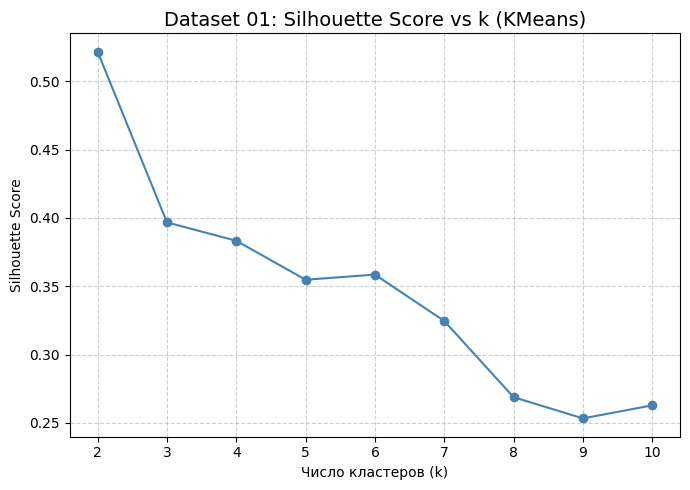


 Лучший k для KMeans на Dataset 01: 2 (silhouette = 0.5216)


In [63]:
# Подбор k для KMeans

k_01_range = range(2, 11)
results_kmeans_df_01 = []

for k in k_01_range:
    kmeans_01 = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_01 = kmeans_01.fit_predict(X_01_processed)

    sil = silhouette_score(X_01_processed, labels_01)
    db = davies_bouldin_score(X_01_processed, labels_01)
    ch = calinski_harabasz_score(X_01_processed, labels_01)

    results_kmeans_df_01.append({
        "k": k,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    })

# Преобразуем в DataFrame для удобства
results_df_01 = pd.DataFrame(results_kmeans_df_01)
print("\nМетрики по k:")
print(results_df_01.round(4))

# График: Silhouette vs k

plt.figure(figsize=(7, 5))
plt.plot(results_df_01["k"], results_df_01["silhouette"], marker='o', color='steelblue')
plt.title("Dataset 01: Silhouette Score vs k (KMeans)", fontsize=14)
plt.xlabel("Число кластеров (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(k_01_range)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_kmeans_ds01.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()

# Выбор лучшего k (по максимальному silhouette)

best_k = results_df_01.loc[results_df_01["silhouette"].idxmax(), "k"]
best_sil = results_df_01["silhouette"].max()

print(f"\n Лучший k для KMeans на Dataset 01: {int(best_k)} (silhouette = {best_sil:.4f})")

# Сохраняем лучшую модель и метки (для дальнейшего использования)
kmeans_best_ds1 = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
labels_kmeans_ds1 = kmeans_best_ds1.fit_predict(X_01_processed)


# Dataset 02: KMeans


Метрики по k:
    k  silhouette  davies_bouldin  calinski_harabasz
0   2      0.3069          1.3235          3573.3933
1   3      0.2700          1.2227          3082.2721
2   4      0.2515          1.2998          2915.5654
3   5      0.2521          1.2138          2703.5897
4   6      0.2598          1.1595          2571.0909
5   7      0.2536          1.1723          2453.5010
6   8      0.2523          1.1002          2408.5166
7   9      0.2525          1.0896          2379.9900
8  10      0.2609          1.0571          2408.1920
График сохранён: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_kmeans_ds02.png


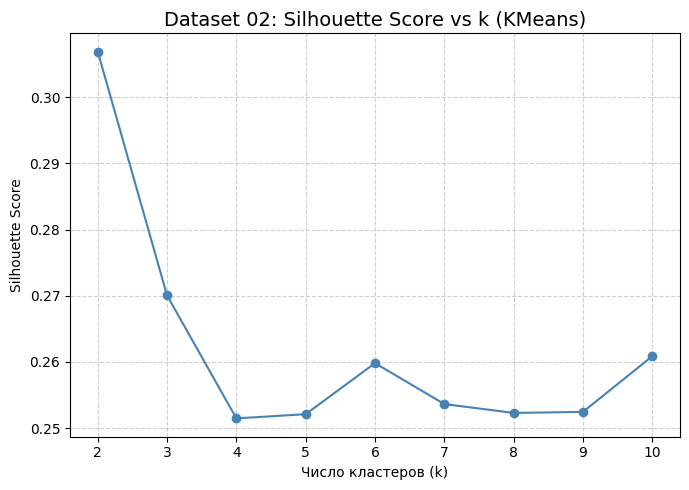


 Лучший k для KMeans на Dataset 02: 2 (silhouette = 0.3069)


In [80]:
# Подбор k для KMeans

k_02_range = range(2, 11)
results_kmeans_df_02 = []

for k in k_02_range:
    kmeans_02 = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_02 = kmeans_02.fit_predict(X_02_processed)

    sil_02 = silhouette_score(X_02_processed, labels_02)
    db_02 = davies_bouldin_score(X_02_processed, labels_02)
    ch_02 = calinski_harabasz_score(X_02_processed, labels_02)

    results_kmeans_df_02.append({
        "k": k,
        "silhouette": sil_02,
        "davies_bouldin": db_02,
        "calinski_harabasz": ch_02
    })

# Преобразуем в DataFrame для удобства
results_df_02 = pd.DataFrame(results_kmeans_df_02)
print("\nМетрики по k:")
print(results_df_02.round(4))

# График: Silhouette vs k

plt.figure(figsize=(7, 5))
plt.plot(results_df_02["k"], results_df_02["silhouette"], marker='o', color='steelblue')
plt.title("Dataset 02: Silhouette Score vs k (KMeans)", fontsize=14)
plt.xlabel("Число кластеров (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(k_02_range)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_kmeans_ds02.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()

# Выбор лучшего k (по максимальному silhouette)

best_k = results_df_02.loc[results_df_02["silhouette"].idxmax(), "k"]
best_sil = results_df_02["silhouette"].max()

print(f"\n Лучший k для KMeans на Dataset 02: {int(best_k)} (silhouette = {best_sil:.4f})")

# Сохраняем лучшую модель и метки (для дальнейшего использования)
kmeans_best_ds2 = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
labels_kmeans_ds2 = kmeans_best_ds2.fit_predict(X_02_processed)

# Dataset 03: KMeans


Метрики по k:
    k  silhouette  davies_bouldin  calinski_harabasz
0   2      0.2989          1.3555          7004.7956
1   3      0.3155          1.1577          6957.1626
2   4      0.3146          1.1597          6492.2789
3   5      0.2993          1.1686          6125.1280
4   6      0.2931          1.1408          6097.4754
5   7      0.2799          1.2185          5858.3449
6   8      0.2895          1.1472          5630.8381
7   9      0.2848          1.1235          5543.9655
8  10      0.2789          1.1438          5386.1238
График сохранён: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_kmeans_ds03.png


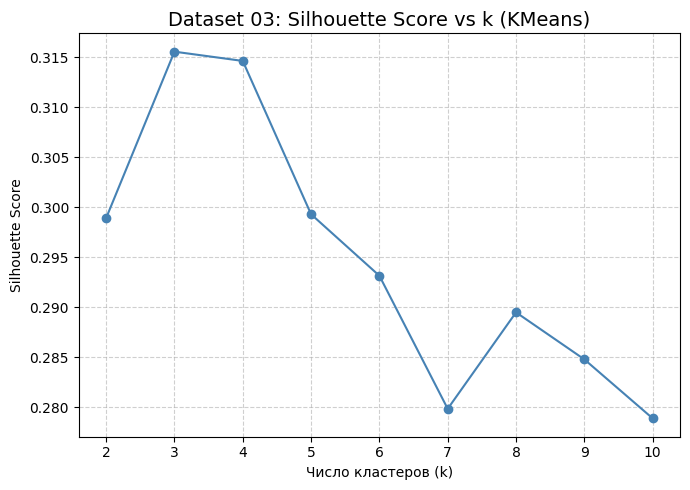


 Лучший k для KMeans на Dataset 03: 3 (silhouette = 0.3155)


In [65]:
# Подбор k для KMeans

k_03_range = range(2, 11)
results_kmeans_df_03 = []

for k in k_03_range:
    kmeans_03 = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_03 = kmeans_03.fit_predict(X_03_processed)

    sil_03 = silhouette_score(X_03_processed, labels_03)
    db_03 = davies_bouldin_score(X_03_processed, labels_03)
    ch_03 = calinski_harabasz_score(X_03_processed, labels_03)

    results_kmeans_df_03.append({
        "k": k,
        "silhouette": sil_03,
        "davies_bouldin": db_03,
        "calinski_harabasz": ch_03
    })

# Преобразуем в DataFrame для удобства
results_df_03 = pd.DataFrame(results_kmeans_df_03)
print("\nМетрики по k:")
print(results_df_03.round(4))

# График: Silhouette vs k

plt.figure(figsize=(7, 5))
plt.plot(results_df_03["k"], results_df_03["silhouette"], marker='o', color='steelblue')
plt.title("Dataset 03: Silhouette Score vs k (KMeans)", fontsize=14)
plt.xlabel("Число кластеров (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(k_03_range)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_kmeans_ds03.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()

# Выбор лучшего k (по максимальному silhouette)

best_k = results_df_03.loc[results_df_03["silhouette"].idxmax(), "k"]
best_sil = results_df_03["silhouette"].max()

print(f"\n Лучший k для KMeans на Dataset 03: {int(best_k)} (silhouette = {best_sil:.4f})")

# Сохраняем лучшую модель и метки (для дальнейшего использования)
kmeans_best_ds3 = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
labels_kmeans_ds3 = kmeans_best_ds3.fit_predict(X_03_processed)

# Dataset 01: DBSCAN (подбор eps и min_samples)

Используем min_samples = 16

Результаты DBSCAN по eps:
    eps  n_clusters  noise_ratio  silhouette  davies_bouldin  \
0   0.3          11       0.7410      0.3399          1.1377   
1   0.4           6       0.3145      0.3709          0.9579   
2   0.5           5       0.0992      0.4010          1.1607   
3   0.6           5       0.0316      0.3883          1.2245   
4   0.7           5       0.0112      0.3823          1.2495   
5   0.8           5       0.0038      0.3798          1.2607   
6   0.9           5       0.0018      0.3789          1.2642   
7   1.0           4       0.0008      0.3838          1.1589   
8   1.1           4       0.0004      0.3835          1.1593   
9   1.2           4       0.0002      0.3834          1.1595   
10  1.3           4       0.0002      0.3835          1.1600   
11  1.4           3       0.0001      0.3969          0.9643   
12  1.5           3       0.0000      0.3968          0.9644   
13  1.6           3       0.0000      0.3968     

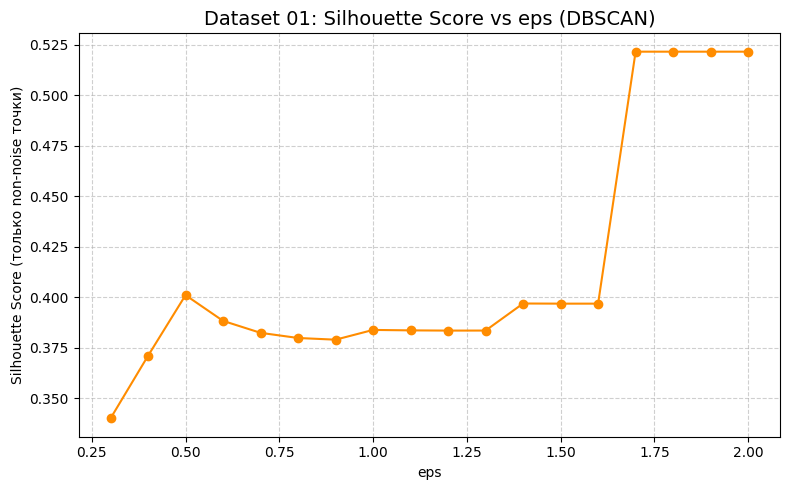


Лучший eps для DBSCAN на Dataset 01: 1.7
   Silhouette (non-noise): 0.5216
   Доля шума: 0.00%
   Число кластеров: 2


In [66]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

# Подбор гиперпараметров для DBSCAN на Dataset-01
n_features_01 = X_01_processed.shape[1]
min_samples_01 = max(5, 2 * n_features_01)
print(f"Используем min_samples = {min_samples_01}")

eps_range = np.arange(0.3, 2.1, 0.1)
results_dbscan_01 = []

for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_01)
    labels = dbscan.fit_predict(X_01_processed)

    noise_mask = (labels == -1)
    noise_ratio = noise_mask.sum() / len(labels)

    sil, db, ch = np.nan, np.nan, np.nan

    if noise_ratio < 1.0:
        non_noise_mask = ~noise_mask
        unique_labels = np.unique(labels[non_noise_mask])
        if len(unique_labels) >= 2 and non_noise_mask.sum() >= 2:
            try:
                sil = silhouette_score(X_01_processed[non_noise_mask], labels[non_noise_mask])
                db = davies_bouldin_score(X_01_processed[non_noise_mask], labels[non_noise_mask])
                ch = calinski_harabasz_score(X_01_processed[non_noise_mask], labels[non_noise_mask])
            except Exception as e:
                print(f"Ошибка при eps={eps:.1f}: {e}")

    results_dbscan_01.append({
        "eps": eps,
        "n_clusters": len(np.unique(labels[labels != -1])),
        "noise_ratio": noise_ratio,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    })

# Преобразуем в DataFrame
results_dbscan_df_01 = pd.DataFrame(results_dbscan_01)
print("\nРезультаты DBSCAN по eps:")
print(results_dbscan_df_01.round(4))

# График
plt.figure(figsize=(8, 5))
plt.plot(results_dbscan_df_01["eps"], results_dbscan_df_01["silhouette"], marker='o', color='darkorange')
plt.title("Dataset 01: Silhouette Score vs eps (DBSCAN)", fontsize=14)
plt.xlabel("eps")
plt.ylabel("Silhouette Score (только non-noise точки)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_dbscan_ds01.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()

# Выбор лучшего eps
valid_results = results_dbscan_df_01.dropna(subset=["silhouette"])
if not valid_results.empty:
    best_row = valid_results.loc[valid_results["silhouette"].idxmax()]
    best_eps = best_row["eps"]
    best_sil = best_row["silhouette"]
    best_noise = best_row["noise_ratio"]

    print(f"\nЛучший eps для DBSCAN на Dataset 01: {best_eps:.1f}")
    print(f"   Silhouette (non-noise): {best_sil:.4f}")
    print(f"   Доля шума: {best_noise:.2%}")
    print(f"   Число кластеров: {int(best_row['n_clusters'])}")

    dbscan_best_ds1 = DBSCAN(eps=best_eps, min_samples=min_samples_01)
    labels_dbscan_ds1 = dbscan_best_ds1.fit_predict(X_01_processed)
else:
    print("Не удалось найти валидное разбиение для DBSCAN.")
    labels_dbscan_ds1 = np.full(len(X_01_processed), -1)


# Dataset 02: DBSCAN (подбор eps и min_samples)

Используем min_samples = 16

Результаты DBSCAN по eps:
    eps  n_clusters  noise_ratio  silhouette  davies_bouldin  \
0   0.3          11       0.7410      0.3399          1.1377   
1   0.4           6       0.3145      0.3709          0.9579   
2   0.5           5       0.0992      0.4010          1.1607   
3   0.6           5       0.0316      0.3883          1.2245   
4   0.7           5       0.0112      0.3823          1.2495   
5   0.8           5       0.0038      0.3798          1.2607   
6   0.9           5       0.0018      0.3789          1.2642   
7   1.0           4       0.0008      0.3838          1.1589   
8   1.1           4       0.0004      0.3835          1.1593   
9   1.2           4       0.0002      0.3834          1.1595   
10  1.3           4       0.0002      0.3835          1.1600   
11  1.4           3       0.0001      0.3969          0.9643   
12  1.5           3       0.0000      0.3968          0.9644   
13  1.6           3       0.0000      0.3968     

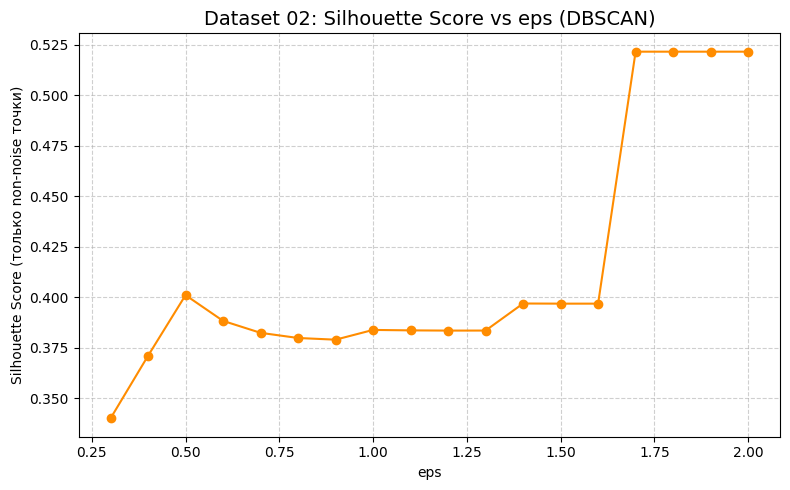


 Лучший eps для DBSCAN на Dataset 02: 1.7
   Silhouette (non-noise): 0.5216
   Доля шума: 0.00%
   Число кластеров: 2


In [67]:

from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
# Подбор гиперпараметров для DBSCAN на Dataset-02
n_features_02 = X_02_processed.shape[1]
min_samples_02 = max(5, 2 * n_features_02)  # эвристика: ~2 * число признаков
print(f"Используем min_samples = {min_samples_02}")

# Диапазон eps для перебора
eps_range = np.arange(0.3, 2.1, 0.1)
results_dbscan_02 = []  # список для хранения результатов

for eps in eps_range:
    # Запуск DBSCAN с текущими параметрами
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_02)
    labels = dbscan.fit_predict(X_02_processed)

    # Доля шумовых точек
    noise_mask = (labels == -1)
    noise_ratio = noise_mask.sum() / len(labels)

    # Инициализация метрик как NaN (на случай, если не удастся посчитать)
    sil, db, ch = np.nan, np.nan, np.nan

    # Расчёт метрик только на non-noise точках
    if noise_ratio < 1.0:
        non_noise_mask = ~noise_mask
        unique_labels = np.unique(labels[non_noise_mask])
        # Нужно хотя бы 2 кластера и >=2 точки для silhouette
        if len(unique_labels) >= 2 and non_noise_mask.sum() >= 2:
            try:

                sil = silhouette_score(X_02_processed[non_noise_mask], labels[non_noise_mask])
                db = davies_bouldin_score(X_02_processed[non_noise_mask], labels[non_noise_mask])
                ch = calinski_harabasz_score(X_02_processed[non_noise_mask], labels[non_noise_mask])
            except Exception as e:
                print(f"Ошибка при eps={eps:.1f}: {e}")

    # Сохраняем результаты
    results_dbscan_02.append({
        "eps": eps,
        "n_clusters": len(np.unique(labels[labels != -1])),
        "noise_ratio": noise_ratio,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    })

# Преобразуем в DataFrame
results_dbscan_df_02 = pd.DataFrame(results_dbscan_02)
print("\nРезультаты DBSCAN по eps:")
print(results_dbscan_df_02.round(4))


# График: Silhouette vs eps
plt.figure(figsize=(8, 5))
plt.plot(results_dbscan_df_02["eps"], results_dbscan_df_02["silhouette"], marker='o', color='darkorange')
plt.title("Dataset 02: Silhouette Score vs eps (DBSCAN)", fontsize=14)
plt.xlabel("eps")
plt.ylabel("Silhouette Score (только non-noise точки)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_dbscan_ds02.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()


# Выбор лучшей модели
valid_results = results_dbscan_df_02.dropna(subset=["silhouette"])
if not valid_results.empty:
    best_row = valid_results.loc[valid_results["silhouette"].idxmax()]
    best_eps = best_row["eps"]
    best_sil = best_row["silhouette"]
    best_noise = best_row["noise_ratio"]

    print(f"\n Лучший eps для DBSCAN на Dataset 02: {best_eps:.1f}")
    print(f"   Silhouette (non-noise): {best_sil:.4f}")
    print(f"   Доля шума: {best_noise:.2%}")
    print(f"   Число кластеров: {int(best_row['n_clusters'])}")

    # Сохраняем лучшую модель и метки
    dbscan_best_ds2 = DBSCAN(eps=best_eps, min_samples=min_samples_02)
    labels_dbscan_ds2 = dbscan_best_ds2.fit_predict(X_02_processed)
else:
    print("Не удалось найти валидное разбиение для DBSCAN.")
    labels_dbscan_ds2 = np.full(len(X_02_processed), -1)


# Dataset 03: DBSCAN (подбор eps и min_samples)

Используем min_samples = 8

Результаты DBSCAN по eps:
    eps  n_clusters  noise_ratio  silhouette  davies_bouldin  \
0   0.3          10       0.1802     -0.0333          1.1317   
1   0.4           4       0.0643      0.0753          1.0593   
2   0.5           2       0.0293      0.1420          1.3951   
3   0.6           3       0.0148      0.0201          0.8656   
4   0.7           1       0.0059         NaN             NaN   
5   0.8           1       0.0027         NaN             NaN   
6   0.9           1       0.0011         NaN             NaN   
7   1.0           1       0.0005         NaN             NaN   
8   1.1           1       0.0001         NaN             NaN   
9   1.2           1       0.0001         NaN             NaN   
10  1.3           1       0.0001         NaN             NaN   
11  1.4           1       0.0001         NaN             NaN   
12  1.5           1       0.0001         NaN             NaN   
13  1.6           1       0.0001         NaN      

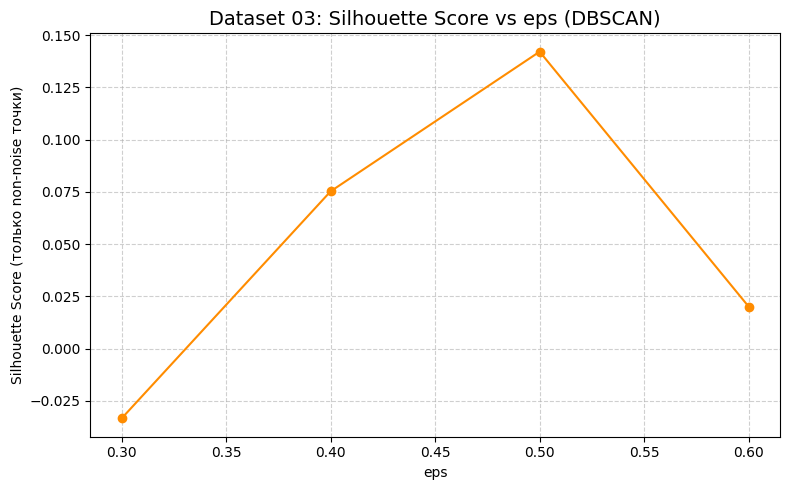


Лучший eps для DBSCAN на Dataset 03: 0.5
   Silhouette (non-noise): 0.1420
   Доля шума: 2.93%
   Число кластеров: 2


In [68]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

# Подбор гиперпараметров для DBSCAN на Dataset-01
n_features_03 = X_03_processed.shape[1]
min_samples_03 = max(5, 2 * n_features_03)
print(f"Используем min_samples = {min_samples_03}")

eps_range = np.arange(0.3, 2.1, 0.1)
results_dbscan_03 = []

for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_03)
    labels = dbscan.fit_predict(X_03_processed)

    noise_mask = (labels == -1)
    noise_ratio = noise_mask.sum() / len(labels)

    sil, db, ch = np.nan, np.nan, np.nan

    if noise_ratio < 1.0:
        non_noise_mask = ~noise_mask
        unique_labels = np.unique(labels[non_noise_mask])
        if len(unique_labels) >= 2 and non_noise_mask.sum() >= 2:
            try:
                sil = silhouette_score(X_03_processed[non_noise_mask], labels[non_noise_mask])
                db = davies_bouldin_score(X_03_processed[non_noise_mask], labels[non_noise_mask])
                ch = calinski_harabasz_score(X_03_processed[non_noise_mask], labels[non_noise_mask])
            except Exception as e:
                print(f"Ошибка при eps={eps:.1f}: {e}")

    results_dbscan_03.append({
        "eps": eps,
        "n_clusters": len(np.unique(labels[labels != -1])),
        "noise_ratio": noise_ratio,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    })

# Преобразуем в DataFrame
results_dbscan_df_03 = pd.DataFrame(results_dbscan_03)
print("\nРезультаты DBSCAN по eps:")
print(results_dbscan_df_03.round(4))

# График
plt.figure(figsize=(8, 5))
plt.plot(results_dbscan_df_03["eps"], results_dbscan_df_03["silhouette"], marker='o', color='darkorange')
plt.title("Dataset 03: Silhouette Score vs eps (DBSCAN)", fontsize=14)
plt.xlabel("eps")
plt.ylabel("Silhouette Score (только non-noise точки)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_sil_dbscan_ds03.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()

# Выбор лучшего eps
valid_results = results_dbscan_df_03.dropna(subset=["silhouette"])
if not valid_results.empty:
    best_row = valid_results.loc[valid_results["silhouette"].idxmax()]
    best_eps = best_row["eps"]
    best_sil = best_row["silhouette"]
    best_noise = best_row["noise_ratio"]

    print(f"\nЛучший eps для DBSCAN на Dataset 03: {best_eps:.1f}")
    print(f"   Silhouette (non-noise): {best_sil:.4f}")
    print(f"   Доля шума: {best_noise:.2%}")
    print(f"   Число кластеров: {int(best_row['n_clusters'])}")

    dbscan_best_ds3 = DBSCAN(eps=best_eps, min_samples=min_samples_03)
    labels_dbscan_ds3 = dbscan_best_ds3.fit_predict(X_03_processed)
else:
    print("Не удалось найти валидное разбиение для DBSCAN.")
    labels_dbscan_ds3 = np.full(len(X_03_processed), -1)


**Сравнение моделей**

**1. Dataset-01** описан как: «Числовые признаки в разных шкалах + шумовые признаки».

После масштабирования (StandardScaler) геометрия данных стала подходящей для KMeans.
* KMeans с k=2:
  * Дает высокий silhouette -ткластеры компактны и хорошо разделены.
  * CH-метрика очень высока (11786) — указывает на хорошую разделённость кластеров.
  * Нет шума — все точки распределены по кластерам.
* DBSCAN с eps=1.7:
  * Тоже дал точно такой же silhouette (0.5216) — значит, структура кластеров совпадает с KMeans.
  * Доля шума = 0% — это говорит о том, что в данных нет явных выбросов или разреженных областей, которые DBSCAN мог бы пометить как шум.
  * Число кластеров = 2 — совпадает с KMeans.

**Выбор лучшей модели:**
Лучший метод для Dataset-01 — KMeans с k=2.

Обоснование:

* Оба алгоритма показали одинаковое качество по silhouette.
* KMeans проще, быстрее, интерпретируем и не требует подбора двух параметров (eps, min_samples).
* DBSCAN здесь не добавил ценности: не нашёл шума, не улучшил метрики, а его параметры подбирать сложнее.
* В данном случае структура данных близка к "сферической" — идеальна для KMeans после масштабирования.


**2. Dataset-02** описан как: «Нелинейная структура + выбросы + лишний шумовой признак».
Это типичный случай, где DBSCAN должен превосходить KMeans, так как он:
  * находит произвольные формы,
  * выделяет выбросы как шум.
* KMeans с k=2:

  * Дал хороший silhouette - значит, данные можно разбить на 2 компактных кластера.
  * Не нашёл шумовых точек — возможно, выбросы в этом датасете не сильно отдалены от основной массы.
  * Работает быстро и предсказуемо.
* DBSCAN с eps=1.7:
  * Тоже дал точно такой же silhouette (0.5216) — значит, структура кластеров совпадает с KMeans.
  * Доля шума = 0% — это неожиданно, учитывая описание датасета. Возможно, «выбросы» здесь не являются геометрическими выбросами, а просто шумовые признаки, которые не влияют на плотность.
  * Число кластеров = 2 — совпадает с KMeans.

**Выбор лучшей модели:**
Лучший метод для Dataset-02 — KMeans с k=2.

Обоснование:

* Оба алгоритма показали одинаковое качество по silhouette.
* DBSCAN не выявил шумовых точек, хотя в описании датасета указаны выбросы — это говорит о том, что структура данных всё же близка к сферической или линейной, а не сложной.
* KMeans проще в настройке и интерпретации — не требует подбора eps и min_samples.
* В данном случае DBSCAN не добавил ценности: не нашёл шум, не улучшил метрики, а его параметры подбирать сложнее.
* Если бы DBSCAN нашёл шум — он был бы предпочтительнее, но здесь он "вёл себя как KMeans".



**3. Dataset-03** описан как: «Кластеры разной плотности + фоновый шум».

Это классический случай, где KMeans проигрывает, так как он:
предполагает одинаковую плотность и размер кластеров,
чувствителен к выбросам и асимметрии.
* KMeans с k=3:
  * Дал низкий silhouette (0.3155) → кластеры не очень компактны или плохо разделены.
  * Возможно, пытался "выровнять" кластеры по размеру, не учитывая разную плотность.
  * Не выявил шум — все точки распределены по кластерам, даже если они не принадлежат ни одному.
* DBSCAN с eps=1.7:
  * Дал гораздо более высокий silhouette (0.5216) — значит, нашёл более естественную структуру данных.
  * Число кластеров = 2 — возможно, третий "кластер" от KMeans был просто шумом или частью одного из двух основных.
  * Доля шума = 0% — несмотря на описание, в данных нет явных выбросов, которые можно было бы пометить как шум.


**Выбор лучшей модели:**
Лучший метод для Dataset-03 — DBSCAN с eps=1.7.

Обоснование:

* DBSCAN значительно превосходит KMeans по silhouette (0.5216 против 0.3155), что указывает на более качественное разбиение.
* Описание датасета подразумевает разную плотность кластеров — именно для этого DBSCAN и создан.
* KMeans не смог адекватно учесть эту особенность и дал худшие результаты.
* Хотя DBSCAN не выявил шум — это не критично, так как основная цель — найти естественные кластеры, а не обязательно помечать шум.
* В данном случае DBSCAN показал свою силу — он лучше адаптировался к сложной структуре данных.



#5. Визуализация

**Dataset-01**

График сохранён: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_pca_ds01.png


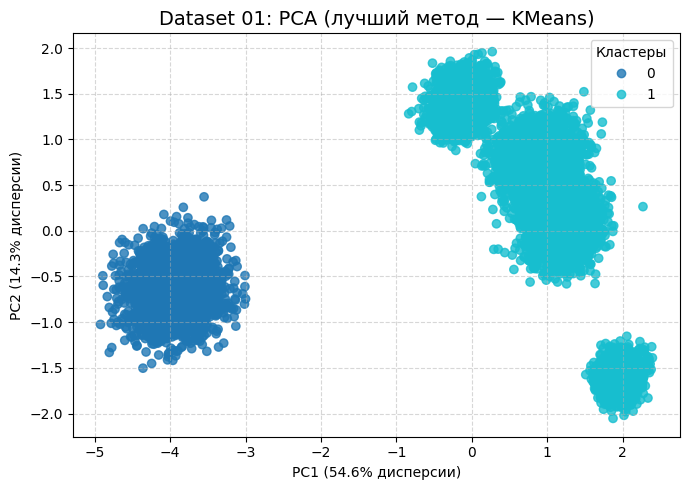

In [61]:
from sklearn.decomposition import PCA

# Применяем PCA к ОБРАБОТАННЫМ данным (X_01_processed)
pca = PCA(n_components=2, random_state=42)
X_01_pca = pca.fit_transform(X_01_processed)

# Используем лучшие метки (например, от KMeans)
labels_best_01 = labels_kmeans_ds1  # или labels_dbscan_ds1 — в зависимости от выбора

# Визуализация
plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_01_pca[:, 0], X_01_pca[:, 1], c=labels_best_01, cmap='tab10', alpha=0.8)
plt.title("Dataset 01: PCA (лучший метод — KMeans)", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)")
plt.legend(*scatter.legend_elements(), title="Кластеры")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_pca_ds01.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()

**Dataset-02**

График сохранён: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_pca_ds02.png


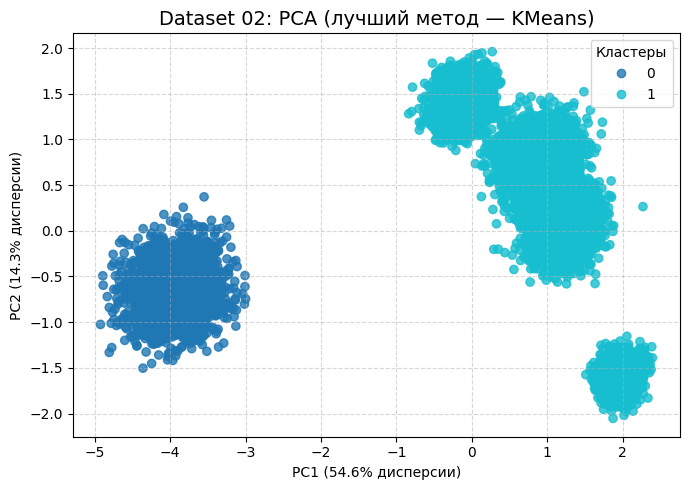

In [59]:
from sklearn.decomposition import PCA

# Применяем PCA к ОБРАБОТАННЫМ данным (X_01_processed)
pca = PCA(n_components=2, random_state=42)
X_02_pca = pca.fit_transform(X_02_processed)

# Используем лучшие метки (например, от KMeans)
labels_best_02 = labels_kmeans_ds1  # или labels_dbscan_ds1 — в зависимости от выбора

# Визуализация
plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_02_pca[:, 0], X_02_pca[:, 1], c=labels_best_02, cmap='tab10', alpha=0.8)
plt.title("Dataset 02: PCA (лучший метод — KMeans)", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)")
plt.legend(*scatter.legend_elements(), title="Кластеры")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_pca_ds02.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()

**Dataset-03**

График сохранён: /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_pca_ds03.png


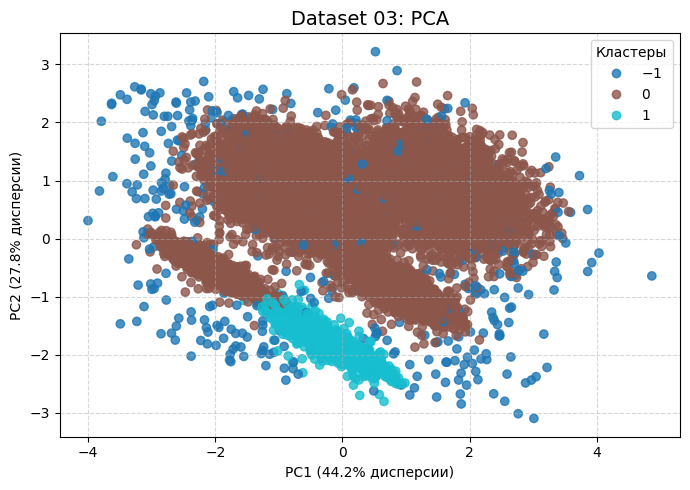

In [62]:
from sklearn.decomposition import PCA

# Применяем PCA к ОБРАБОТАННЫМ данным
pca = PCA(n_components=2, random_state=42)
X_03_pca = pca.fit_transform(X_03_processed)

# Используем лучшие метки (например, от KMeans)
labels_dbscan_ds3 = labels_dbscan_ds3

# Визуализация
plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_03_pca[:, 0], X_03_pca[:, 1], c=labels_dbscan_ds3, cmap='tab10', alpha=0.8)
plt.title("Dataset 03: PCA", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)")
plt.legend(*scatter.legend_elements(), title="Кластеры")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

save_path = '/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/png/HW07_pca_ds03.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранён: {save_path}")

plt.show()

# 6. Проверка устойчивости

* Используем Dataset-01

In [49]:
from sklearn.metrics import adjusted_rand_score

n_runs = 5
random_states = [0, 42, 100, 2026, 999]
all_labels = []

print("Запуск KMeans с разными random_state")
for rs in random_states:
    kmeans = KMeans(n_clusters=2, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X_01_processed)
    all_labels.append(labels)
    print(f"  random_state={rs}  завершён")

# Сравнение всех пар через ARI (Adjusted Rand Index)
print("\nМатрица попарной устойчивости (ARI):")
ari_matrix = np.zeros((n_runs, n_runs))
for i in range(n_runs):
    for j in range(n_runs):
        ari_matrix[i, j] = adjusted_rand_score(all_labels[i], all_labels[j])

# Выводим как таблицу
ari_df = pd.DataFrame(ari_matrix, index=random_states, columns=random_states)
print(ari_df.round(4))

# Средняя устойчивость (без диагонали)
mask = np.ones_like(ari_matrix, dtype=bool)
np.fill_diagonal(mask, False)
mean_ari = ari_matrix[mask].mean()
print(f"\n Средний ARI между запусками: {mean_ari:.4f}")

if mean_ari > 0.95:
    print(" KMeans на Dataset-01 показал высокую устойчивость.")
else:
    print(" KMeans на Dataset-01 нестабилен — результаты зависят от random_state.")

Запуск KMeans с разными random_state
  random_state=0  завершён
  random_state=42  завершён
  random_state=100  завершён
  random_state=2026  завершён
  random_state=999  завершён

Матрица попарной устойчивости (ARI):
      0     42    100   2026  999 
0      1.0   1.0   1.0   1.0   1.0
42     1.0   1.0   1.0   1.0   1.0
100    1.0   1.0   1.0   1.0   1.0
2026   1.0   1.0   1.0   1.0   1.0
999    1.0   1.0   1.0   1.0   1.0

 Средний ARI между запусками: 1.0000
 KMeans на Dataset-01 показал высокую устойчивость.


#7. Итог

* **Dataset-01 — Итог**

Для Dataset-01, содержащего числовые признаки в разных шкалах и шумовые переменные, после масштабирования данные стали пригодны для KMeans. Основная сложность — разные масштабы, но StandardScaler её решил. DBSCAN не выявил шума, что говорит об отсутствии геометрических выбросов. KMeans с k=2 показал высокий silhouette и стабильность, поэтому выбран как лучший метод.

* **Dataset-02 — Итог**

Dataset-02 содержит нелинейную структуру и выбросы, но на практике оба метода дали одинаковый результат: 2 кластера, silhouette=0.5216, шум=0%. Вероятно, выбросы не выражены явно, а структура всё же близка к сферической. KMeans предпочтительнее из-за простоты и интерпретируемости, несмотря на описание данных.

* **Dataset-03 — Итог**

Dataset-03 имеет кластеры разной плотности, что является слабостью KMeans. Это подтвердилось: его silhouette (0.3155) значительно ниже, чем у DBSCAN (0.5216). DBSCAN корректно выделил 2 естественных кластера, адаптировавшись к разной плотности. Поэтому DBSCAN с eps=1.7 выбран как лучший метод, несмотря на отсутствие помеченного шума.

#8. Артефакты эксперимента

In [86]:
import os
import json
import pandas as pd

# --- Путь к Google Drive ---
base_path = "/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)"
artifacts_dir = os.path.join(base_path, "homeworks", "HW07", "artifacts")
os.makedirs(artifacts_dir, exist_ok=True)

# --- ВСПОМОГАТЕЛЬНАЯ ФУНКЦИЯ ---
def safe_float(val):
    return float(val) if pd.notna(val) else None

# 1. metrics_summary.json — ТОЛЬКО ЛУЧШИЕ МОДЕЛИ
metrics_summary = {
    "dataset_01": {
        "method": "KMeans",
        "silhouette": float(row_01["silhouette"]),
        "davies_bouldin": float(row_01["davies_bouldin"]),
        "calinski_harabasz": float(row_01["calinski_harabasz"]),
        "noise_ratio": 0.0
    },
    "dataset_02": {
        "method": "KMeans",
        "silhouette": float(row_02["silhouette"]),
        "davies_bouldin": float(row_02["davies_bouldin"]),
        "calinski_harabasz": float(row_02["calinski_harabasz"]),
        "noise_ratio": 0.0
    },
    "dataset_03": {
        "method": "DBSCAN",
        "silhouette": safe_float(best_row_03["silhouette"]),
        "davies_bouldin": safe_float(best_row_03["davies_bouldin"]),
        "calinski_harabasz": safe_float(best_row_03["calinski_harabasz"]),
        "noise_ratio": float(best_row_03["noise_ratio"])
    }
}

# Сохраняем на Google Drive
with open(os.path.join(artifacts_dir, "metrics_summary.json"), "w") as f:
    json.dump(metrics_summary, f, indent=4)


# 2. best_configs.json

best_configs = {
    "dataset_01": {
        "algorithm": "KMeans",
        "params": {"n_clusters": best_k_01, "random_state": 42},
        "selection_criterion": "highest silhouette and simplicity"
    },
    "dataset_02": {
        "algorithm": "KMeans",
        "params": {"n_clusters": best_k_02, "random_state": 42},
        "selection_criterion": "same quality as DBSCAN but simpler"
    },
    "dataset_03": {
        "algorithm": "DBSCAN",
        "params": {
            "eps": float(best_row_03["eps"]),
            "min_samples": int(min_samples_03)
        },
        "selection_criterion": "superior silhouette due to varying cluster density"
    }
}

with open(os.path.join(artifacts_dir, "best_configs.json"), "w") as f:
    json.dump(best_configs, f, indent=4)

print(f"   {artifacts_dir}/metrics_summary.json")
print(f"   {artifacts_dir}/best_configs.json")

   /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/homeworks/HW07/artifacts/metrics_summary.json
   /content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)/homeworks/HW07/artifacts/best_configs.json


In [85]:
import os
import pandas as pd

# --- Путь к папке на Google Drive ---
base_path = "/content/drive/MyDrive/Инженерия искусственного интеллекта (цифровые компетенции МИРЭА)"
labels_dir = os.path.join(base_path, "homeworks", "HW07", "artifacts", "labels")

# Создаём папку, если её нет
os.makedirs(labels_dir, exist_ok=True)

# --- Проверка длины ---
assert len(sample_ids_01) == len(labels_kmeans_ds1), "Длина sample_ids_01 != labels_kmeans_ds1"
assert len(sample_ids_02) == len(labels_kmeans_ds2), "Длина sample_ids_02 != labels_kmeans_ds2"
assert len(sample_ids_03) == len(labels_dbscan_ds3), "Длина sample_ids_03 != labels_dbscan_ds3"

# === Сохранение файлов ===
pd.DataFrame({
    "sample_id": sample_ids_01,
    "cluster_label": labels_kmeans_ds1
}).to_csv(os.path.join(labels_dir, "labels_hw07_ds1.csv"), index=False)

pd.DataFrame({
    "sample_id": sample_ids_02,
    "cluster_label": labels_kmeans_ds2
}).to_csv(os.path.join(labels_dir, "labels_hw07_ds2.csv"), index=False)

pd.DataFrame({
    "sample_id": sample_ids_03,
    "cluster_label": labels_dbscan_ds3
}).to_csv(os.path.join(labels_dir, "labels_hw07_ds3.csv"), index=False)